## Training

In [1]:
import os

In [2]:
%pwd

'/home/zkhechadoorian/CNNs_Cats_and_Dogs/research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/home/zkhechadoorian/CNNs_Cats_and_Dogs'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list
    scan_over_freeze_till_models_path: Path  # <-- Add this line


@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [6]:
from ImageClassification.constants import *
from ImageClassification.utils import read_yaml, create_directories
import tensorflow as tf
tf.config.run_functions_eagerly(True)

2025-09-17 03:22:02.942237: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 03:22:02.942678: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 03:22:03.008625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-17 03:22:04.631681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [7]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "PetImages")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE,
            scan_over_freeze_till_models_path=Path(training.scan_over_freeze_till_models_path)
        )

        return training_config

In [8]:
import time

In [9]:
class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config

    
    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    


    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),  # Convert WindowsPath to string
            save_best_only=True
        )


    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [10]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time

In [11]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path, compile=False
        )
        
        self.model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                #brightness_range=[0.7, 1.3],         # Add brightness augmentation
                #channel_shift_range=30.0,            # Add color shift
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )
        return history

In [12]:
# Generate extra augmented cat images and save them to a new folder
os.system('rm artifacts/data_ingestion/PetImages/Cat/*aug*')
os.system('rm -rf artifacts/data_ingestion/PetImages/Cat_augmented')
os.system('mkdir -p artifacts/data_ingestion/PetImages/Cat_augmented')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up augmentation specifically for cats
cat_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    channel_shift_range=30.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Source folder: original cat images
cat_source_dir = 'artifacts/data_ingestion/PetImages/Cat'
# Destination folder: augmented cat images
cat_augmented_dir = 'artifacts/data_ingestion/PetImages/Cat_augmented'

# Create generator to read and augment cat images, saving results
cat_generator = cat_datagen.flow_from_directory(
    directory=os.path.dirname(cat_source_dir),  # parent directory
    classes=['Cat'],                            # only augment Cat class
    target_size=(224, 224),                     # match your model input size
    batch_size=1,
    class_mode=None,
    save_to_dir=cat_augmented_dir,              # save augmented images here
    save_prefix='cat_aug',
    save_format='jpeg'
)

# Generate and save 1000 augmented cat images
for i in range(1000):
    next(cat_generator)

# After running this, add 'Cat_augmented' images to your training set directory.
os.system('mv artifacts/data_ingestion/PetImages/Cat_augmented/* artifacts/data_ingestion/PetImages/Cat/')
os.system('rm -r artifacts/data_ingestion/PetImages/Cat_augmented')

Found 198 images belonging to 1 classes.


0

## Learning Curves: Accuracy and Loss vs. Epochs

In the next cell, we will plot the learning curves for the training process, showing how the model's accuracy and loss evolve over the epochs for both the training and validation datasets.

### Accuracy
Accuracy is a metric that measures the proportion of correctly classified samples out of the total samples. It is calculated as:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

A higher accuracy indicates better model performance. The training accuracy shows how well the model performs on the training data, while the validation accuracy indicates its performance on unseen data.

### Loss
Loss is a measure of the error in the model's predictions. In this project, we use **categorical cross-entropy** as the loss function, which is commonly used for multi-class classification tasks.

Categorical cross-entropy measures the difference between the true label distribution (one-hot encoded) and the predicted probability distribution from the model. It is calculated as:

$$
\text{Loss} = -\sum_{i=1}^{C} y_i \log(p_i)
$$

where:
- $ y_i $ is the true label for class \( i \) (1 for the correct class, 0 for others)
- $ p_i $ is the predicted probability for class \( i \)
- $ C $ is the number of classes

Lower loss values indicate better model performance. Similar to accuracy, we track both training loss and validation loss.

### Interpreting the Graphs
1. **Training Curves**: The training accuracy and loss curves show how well the model is learning from the training data. Ideally, the training accuracy should increase, and the training loss should decrease over epochs.
2. **Validation Curves**: The validation accuracy and loss curves indicate how well the model generalizes to unseen data. Ideally, the validation accuracy should increase, and the validation loss should decrease. If the validation loss starts increasing while the validation accuracy plateaus or decreases, it may indicate overfitting.

By analyzing these graphs, we can assess the model's learning behavior and identify potential issues such as underfitting or overfitting.

[2025-09-17 03:22:18,984: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-09-17 03:22:18,986: INFO: common: yaml file: params.yaml loaded successfully]
[2025-09-17 03:22:18,987: INFO: common: created directory at: artifacts]
[2025-09-17 03:22:18,988: INFO: common: created directory at: artifacts/prepare_callbacks/checkpoint_dir]
[2025-09-17 03:22:18,989: INFO: common: created directory at: artifacts/prepare_callbacks/tensorboard_log_dir]
[2025-09-17 03:22:18,990: INFO: common: created directory at: artifacts/training]


2025-09-17 03:22:19.012415: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 278 images belonging to 2 classes.
Found 1118 images belonging to 2 classes.


/home/zkhechadoorian/CNNs_Cats_and_Dogs/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12


/home/zkhechadoorian/CNNs_Cats_and_Dogs/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 1.3502[2025-09-17 03:23:40,695: WARNING: saving_api: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. ]
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8524 - loss: 0.6887 - val_accuracy: 0.9101 - val_loss: 0.2290
Epoch 2/12
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9044 - loss: 0.2511[2025-09-17 03:25:01,301: WARNING: saving_api: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. ]
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9043 - loss: 0.2651 -

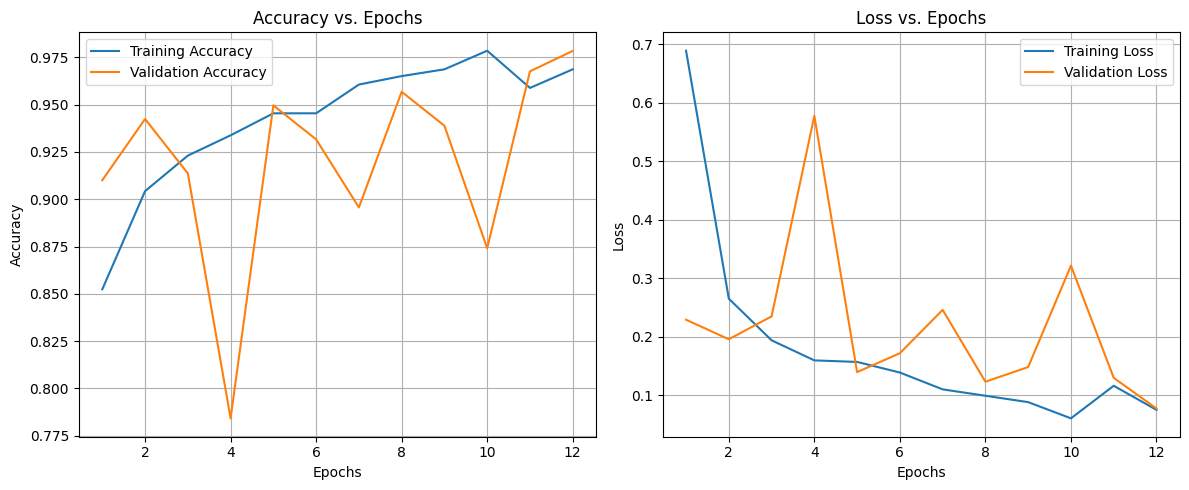

In [13]:
from plot_training_curve import plot_training_curves

try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    history = training.model.fit(
        training.train_generator,
        epochs=training.config.params_epochs,
        #steps_per_epoch=training.steps_per_epoch,
        #alidation_steps=training.validation_steps,
        validation_data=training.valid_generator,
        callbacks=callback_list
    )

    plot_training_curves(history)
    
except Exception as e:
    raise e

## Epoch Selection: Stabilization of Loss

Upon analyzing the loss vs. epochs curve, it is observed that the loss stabilizes around 10-12 epochs. This indicates that the model reaches a point of diminishing returns in terms of improvement in training and validation loss beyond this range. 

To balance training time and model performance, I have decided to use **12 epochs** for training. This choice ensures that the model is trained sufficiently while avoiding unnecessary computational overhead.

## Fine-Tuning with Different Numbers of Trainable Layers

In the next block of code, we perform **fine-tuning** of the model by iteratively unfreezing different numbers of layers in the pre-trained base model. This process involves the following steps:

1. **Freeze Layers**: For each value of `freeze_till` (ranging from 0 to 10), the specified number of layers from the beginning of the model are frozen (i.e., their weights are not updated during training). The remaining layers are set to be trainable.

2. **Re-Compilation**: After modifying the trainable status of the layers, the model is recompiled to ensure the changes take effect.

3. **Training**: The model is trained using the training data and the specified callbacks. The training process adjusts the weights of the trainable layers to improve performance.

4. **Saving the Model**: After training, the model is saved with a unique filename that includes the `freeze_till` value, allowing us to evaluate and compare the performance of models fine-tuned with different numbers of trainable layers.

This approach helps identify the optimal number of layers to unfreeze for fine-tuning, balancing the benefits of leveraging pre-trained features and adapting the model to the specific dataset. The results will be analyzed in subsequent cells to determine the best configuration. 

In [ ]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.train_valid_generator()

    # Loop over freeze_till values
    for freeze_till in range(0, 11, 2):
        print(f"\nTraining with freeze_till={freeze_till}")
        # Load and update the base model for each freeze_till value
        training.get_base_model()  # Loads the base model
        # Freeze layers: you need to add this logic to your Training class or do it here
        for layer in training.model.layers[:-freeze_till] if freeze_till > 0 else []:
            layer.trainable = False
        for layer in training.model.layers[-freeze_till:] if freeze_till > 0 else training.model.layers:
            layer.trainable = True
        # Re-compile after changing trainable status
        training.model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )
        # Train the model
        training.train(callback_list=callback_list)
        # Save with a unique name
        trained_model_path = str(training.config.augmented_model_path).replace(".h5", f"_freeze_{freeze_till}.h5")
        training.save_model(trained_model_path, training.model)
        print(f"Saved model: {trained_model_path}")

except Exception as e:
    raise e

[2025-09-17 03:38:22,741: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-09-17 03:38:22,743: INFO: common: yaml file: params.yaml loaded successfully]
[2025-09-17 03:38:22,744: INFO: common: created directory at: artifacts]
[2025-09-17 03:38:22,745: INFO: common: created directory at: artifacts/prepare_callbacks/checkpoint_dir]
[2025-09-17 03:38:22,745: INFO: common: created directory at: artifacts/prepare_callbacks/tensorboard_log_dir]
[2025-09-17 03:38:22,747: INFO: common: created directory at: artifacts/training]
Found 278 images belonging to 2 classes.
Found 1118 images belonging to 2 classes.

Training with freeze_till=0
Epoch 1/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7881 - loss: nan[2025-09-17 03:39:42,039: WARNING: saving_api: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model

/home/zkhechadoorian/CNNs_Cats_and_Dogs/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9375 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8575 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.8750 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8575 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8750 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8557 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 8/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 9/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8566 - loss: nan - val_accuracy: 0.8787 - val_loss: nan
Epoch 10/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/

Evaluating model: artifacts/training/scan_over_freeze_till_models_freeze_0.h5
[2025-09-17 04:30:14,175: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
freeze_till=0: val_accuracy=0.8597
Evaluating model: artifacts/training/scan_over_freeze_till_models_freeze_1.h5
[2025-09-17 04:30:20,392: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
freeze_till=1: val_accuracy=0.8885
Evaluating model: artifacts/training/scan_over_freeze_till_models_freeze_2.h5
[2025-09-17 04:30:26,547: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
freeze_till=2: val_accuracy=0.9029
Evaluating model: artifacts/training/scan_over_freeze_till

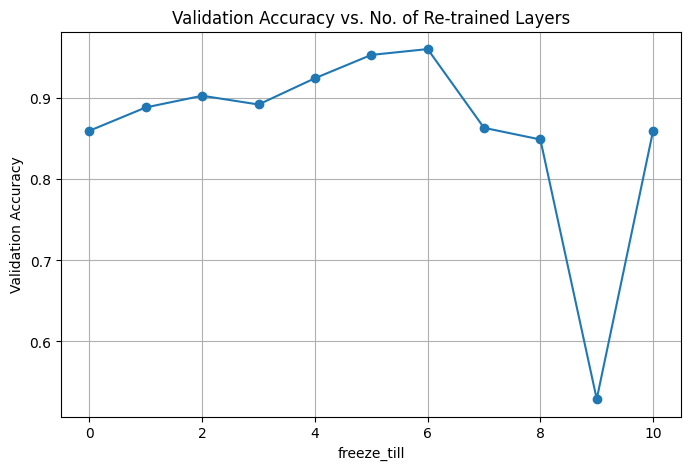

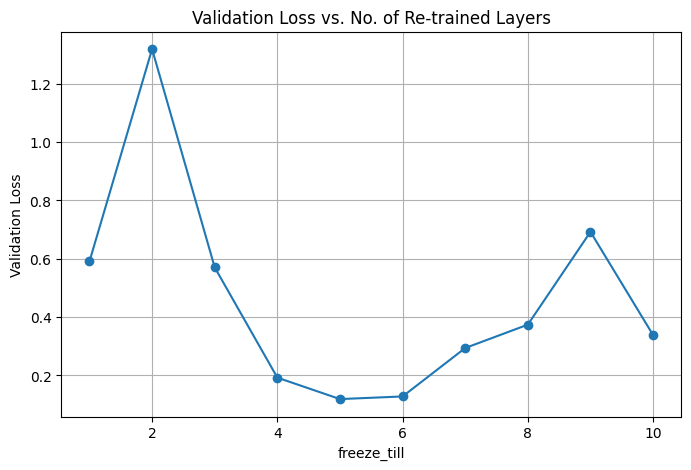

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Prepare to store results
freeze_till_values = []
val_accuracies = []
val_losses = []

# Loop through your saved models
for freeze_till in range(0, 11):
    model_path = str(training.config.scan_over_freeze_till_models_path).replace(".h5", f"_freeze_{freeze_till}.h5")
    print(f"Evaluating model: {model_path}")
    model = tf.keras.models.load_model(model_path)
    # Evaluate on validation data
    loss, acc = model.evaluate(training.valid_generator, verbose=0)
    freeze_till_values.append(freeze_till)
    val_accuracies.append(acc)
    val_losses.append(loss)
    print(f"freeze_till={freeze_till}: val_accuracy={acc:.4f}")

# Plot accuracy vs Freeze_till
plt.figure(figsize=(8, 5))
plt.plot(freeze_till_values, val_accuracies, marker='o')
plt.xlabel('freeze_till')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. No. of Re-trained Layers')
plt.grid(True)
plt.show()

# Plot loss vs Freeze_till
plt.figure(figsize=(8, 5))
plt.plot(freeze_till_values, val_losses, marker='o')
plt.xlabel('freeze_till')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. No. of Re-trained Layers')
plt.grid(True)
plt.show()

## Final Decision: 12 Epochs and freeze_till=6

After analyzing the results of fine-tuning with different numbers of trainable layers, it is evident that the optimal configuration is achieved with **freeze_till=6**. This choice is based on the following observations:

1. **Accuracy**: The validation accuracy is maximized when 4 layers are re-trained, indicating the best generalization performance on unseen data.
2. **Loss**: The validation loss is minimized at the same point, suggesting that the model achieves the lowest error in predictions.

Additionally, the decision to use **12 epochs** is based on the stabilization of the loss curve observed earlier. This ensures that the model is trained sufficiently without overfitting or unnecessary computational overhead.

By using **12 epochs** and **freeze_till=6**, we achieve a balance between training efficiency and model performance, making it the ideal configuration for this task.


## ROC and AUC Curves: Understanding and Interpretation

### ROC Curve
The **Receiver Operating Characteristic (ROC) curve** is a graphical representation of a classification model's performance across different threshold values. It plots the **True Positive Rate (TPR)** (also known as sensitivity or recall) against the **False Positive Rate (FPR)** at various threshold settings.

- **True Positive Rate (TPR)**: The proportion of actual positives correctly identified by the model.
    $$
    TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
    $$
- **False Positive Rate (FPR)**: The proportion of actual negatives incorrectly classified as positives.
    $$
    FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
    $$

The ROC curve provides a comprehensive view of the trade-off between sensitivity and specificity for a classifier.

### AUC (Area Under the Curve)
The **Area Under the Curve (AUC)** quantifies the overall ability of the model to discriminate between positive and negative classes. It is a single scalar value ranging from 0 to 1:
- **AUC = 1**: Perfect classifier.
- **AUC = 0.5**: Random guessing (no discrimination ability).
- **AUC < 0.5**: Worse than random guessing.

### Interpreting the ROC and AUC
1. **Closer to the Top-Left Corner**: A good ROC curve is closer to the top-left corner, indicating high TPR and low FPR.
2. **Higher AUC**: A higher AUC value indicates better model performance. For example:
     - **AUC = 0.9**: Excellent model.
     - **AUC = 0.7–0.8**: Acceptable model.
     - **AUC < 0.7**: Poor model.

### Practical Use
The ROC curve and AUC are particularly useful for evaluating models in imbalanced datasets, where accuracy alone may not provide a complete picture of performance. By analyzing the ROC curve, you can select an optimal threshold that balances sensitivity and specificity based on the problem's requirements.

In [16]:
print(training.valid_generator.class_indices)

{'Cat': 0, 'Dog': 1}


[2025-09-17 04:37:35,265: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]


/home/zkhechadoorian/CNNs_Cats_and_Dogs/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step


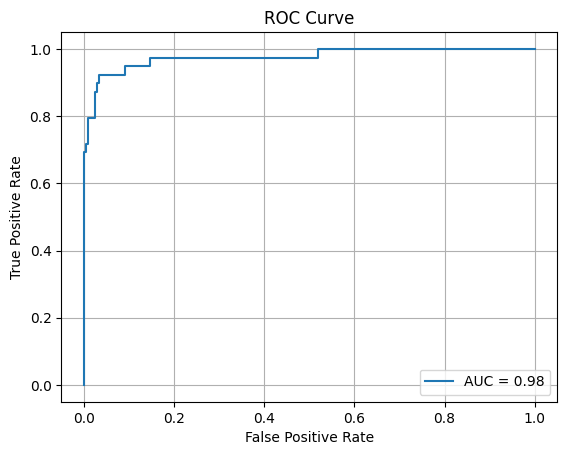

AUC Score: 0.9763


In [ ]:
from src.plot_roc_curve import plot_roc_auc

# use model with 12 epochs and freeze_till=6
model = tf.keras.models.load_model(
    str(training.config.augmented_model_path).replace(".h5", f"_freeze_6.h5")
)

# set y_true and y_pred_proba
y_true = training.valid_generator.classes
y_pred_proba = model.predict(training.valid_generator) # contains probabilities for each class [cat, dog]

# plot_roc_auc(y_true, y_pred_proba, n_classes=None)
plot_roc_auc(y_true, y_pred_proba[:,1], n_classes=None)